
===No.1: R044===

VFI-1: [0]
Loading training and testing set
# of Testing Samples 165
# of Healthy Samples: 3037
# of Fatigued Samples: 3270
batch size: 512


lr find done!


epoch,train_loss,valid_loss,accuracy,time
0,0.754909,0.714575,0.480952,00:04
1,0.748849,0.717104,0.488889,00:04
2,0.737291,0.699520,0.515873,00:04
3,0.720149,0.662336,0.604762,00:04
4,0.696507,0.613506,0.692064,00:04
5,0.667562,0.554215,0.752381,00:05
6,0.631131,0.480809,0.785714,00:04
7,0.586443,0.396896,0.830159,00:04
8,0.537374,0.327961,0.868254,00:04
9,0.490131,0.270779,0.890476,00:04


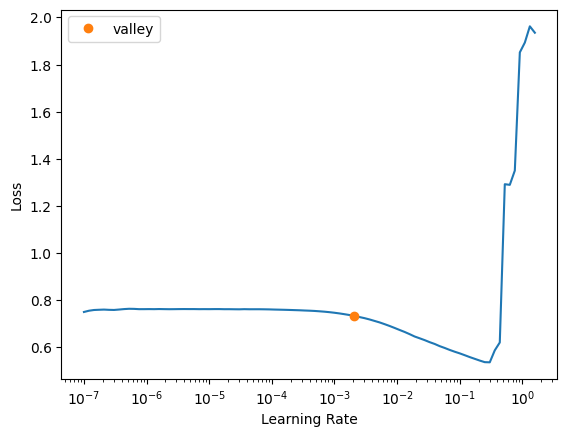

In [11]:
import os
import wandb
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset
from fastai.callback.wandb import WandbCallback
from fastai.data.core import DataLoader, DataLoaders
from fastai.learner import Learner
from tsai.all import get_splits, MLP
from sklearn.metrics import accuracy_score
from util.sEMGhelpers import load_datafile, partition
from cpt import conditional_log_likelihood, cpt_p_pearson_torch, cpt_p_pearson

# environment variable for the experiment
WANDB = os.getenv("WANDB", False)
NAME  = os.getenv("NAME",  "Confounding-Mitigation-In-Deep-Learning")
GROUP = os.getenv("GROUP", "MLP-sEMG-CPT")

class sEMGDataset(Dataset):
  def __init__(self, X, Y, C, index, train=False, sid=None, bs=None):
    self.X, self.Y, self.C, self.i = X, Y, C, index
    self.sid, self.train = sid, train

    if self.train:
      num_batches = len(self.sid) // bs
      i_per_subject = []
      for s in np.unique(self.sid):
        i_subject = [i for i, idx in enumerate(self.i) if self.sid[i] == s]
        i_per_subject.append(i_subject)

      # TODO add a shuffling step
      samples_per_subject = bs // len(np.unique(self.sid))
      extra_samples = bs % len(np.unique(self.sid))
      self.idx = []
      b = 0
      for b in range(num_batches+1):
        for i, indices in enumerate(i_per_subject):
          num_samples = samples_per_subject + (1 if i < extra_samples else 0)
          # print(num_samples)
          if num_samples*(b+1) <= len(indices):
            self.idx.extend(indices[num_samples*b:num_samples*(b+1)])
          else:
            self.idx.extend(indices[num_samples*(b-(len(indices)//num_samples)):num_samples*(b+1-(len(indices)//num_samples))])

  def __len__(self):
    return len(self.Y)

  def __getitem__(self, idx):
    # TODO
    # when idx is 0 reset self.idx
    if self.train:
      # print(self.sid[self.idx[idx]])
      x = torch.tensor(self.X[self.idx[idx],:], dtype=torch.float32)
      c = torch.tensor(self.C[self.idx[idx]],   dtype=torch.float32)
      i = torch.tensor(self.i[self.idx[idx]],   dtype=torch.int)
      y = torch.tensor(self.Y[self.idx[idx]],   dtype=torch.long)
    else:
      x = torch.tensor(self.X[idx,:], dtype=torch.float32)
      c = torch.tensor(self.C[idx],   dtype=torch.float32)
      i = torch.tensor(self.i[idx],   dtype=torch.int)
      y = torch.tensor(self.Y[idx],   dtype=torch.long)
    return (x, c, i), y

# model is the same but passing an additional input variable
class MLP_CPT(MLP):
  def __init__(self, c_in, c_out, seq_len, layers,
               ps=[0.1, 0.2, 0.2], act=nn.ReLU(inplace=True), use_bn=False, bn_final=False, lin_first=False, fc_dropout=0., y_range=None):
    super().__init__(c_in, c_out, seq_len, layers,
                     ps, act, use_bn, bn_final, lin_first, fc_dropout, y_range)

  def forward(self, x_c_idx):
    x, c, idx = x_c_idx
    return (super().forward(x), c, idx)

class CrossEntropyLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def __call__(self, yhat_c_idx, y):
    yhat, _, _ = yhat_c_idx
    return F.cross_entropy(yhat, y)

flag_lr_find = 1
p_log = []
l_log = []
class CrossEntropyCPTLoss(nn.Module):
  def __init__(self, cond_like_mat, train_idx, mcmc_steps=50, random_state=123, num_perm=1000):
    super().__init__()
    self.mcmc_steps        = mcmc_steps   # this is the default value used inside original CPT function
    self.random_state      = random_state
    self.num_perm          = num_perm
    self.cond_log_like_mat = cond_like_mat
    self.train_idx         = train_idx

  def __call__(self, yhat_c_idx, y):
    yhat, c, idx = yhat_c_idx
    p = cpt_p_pearson_torch(c.numpy(), yhat.argmax(dim=1), self.cond_log_like_mat[idx,:][:,idx], self.mcmc_steps, self.random_state, self.num_perm)
    l = F.cross_entropy(yhat, y)
    if flag_lr_find == 0 and np.all(np.isin(idx.numpy(), self.train_idx)) :
      p_log.append(p.detach().numpy())
      l_log.append(l.detach().numpy())
    return l

def accuracy(preds_confound_index, targets):
  preds, _, _ = preds_confound_index
  return (preds.argmax(dim=-1) == targets).float().mean()



if __name__ == "__main__":
  # TODO
  # add input argument for the experiments
  FEAT_N, LABEL, SUBJECT_SKINFOLD, VFI_1, SUBJECT_ID = load_datafile("../data/subjects_40_v6")

  train_acc = np.zeros(40)
  valid_acc = np.zeros(40)
  test_acc  = np.zeros(40)
  p_value   = np.zeros(40)

  sub_test = 0
  sub_txt = "R%03d"%(int(SUBJECT_ID[sub_test][0][0]))
  sub_group = "Fatigued" if int(VFI_1[sub_test][0][0][0]) > 10 else "Healthy"
  print('\n===No.%d: %s===\n'%(sub_test+1, sub_txt))
  print('VFI-1:', (VFI_1[sub_test][0][0]))

  cbs = None
  if WANDB:
    run = wandb.init(project=NAME, group=GROUP, name=sub_txt, tags=[sub_group], reinit=True)
    cbs = WandbCallback(log_preds=False)

  print("Loading training and testing set")
  X_Train, Y_Train, C_Train, ID_Train, X_Test, Y_Test, C_Test, ID_Test = partition(FEAT_N, LABEL, SUBJECT_SKINFOLD, sub_test, SUBJECT_ID)
  Y_Train = np.where(Y_Train == -1, 0, 1)
  Y_Test  = np.where(Y_Test  == -1, 0, 1)

  bs = 512
  print(f"batch size: {bs}")

  # initialization for CPT
  cond_like_mat = conditional_log_likelihood(X=C_Train, C=Y_Train, xdtype='categorical')

  # Setting "stratify" to True ensures that the relative class frequencies are approximately preserved in each train and validation fold
  splits = get_splits(Y_Train, valid_size=.1, stratify=True, random_state=123, shuffle=True, show_plot=False)
  dsets_train = sEMGDataset(X_Train[splits[0],:], Y_Train[splits[0]], C_Train[splits[0]], splits[0], train=True, sid=ID_Train[splits[0]], bs=bs)
  dsets_valid = sEMGDataset(X_Train[splits[1],:], Y_Train[splits[1]], C_Train[splits[1]], splits[1])
  dsets_test  = sEMGDataset(X_Test, Y_Test, C_Test, list(np.arange(len(X_Test))))

  dl_train = DataLoader(dsets_train, shuffle=False, bs=bs, drop_last=True)
  dl_valid = DataLoader(dsets_valid, shuffle=False, bs=bs)
  dls = DataLoaders(dl_train, dl_valid)

  model = MLP_CPT(c_in=1, c_out=2, seq_len=48, layers=[50, 50, 50], use_bn=True)
  learn = Learner(dls, model, loss_func=CrossEntropyCPTLoss(cond_like_mat, splits[0]), metrics=[accuracy], cbs=cbs)

  flag_lr_find = 1
  learn.lr_find()
  print("lr find done!")
  flag_lr_find = 0
  learn.fit_one_cycle(50, lr_max=1e-3)


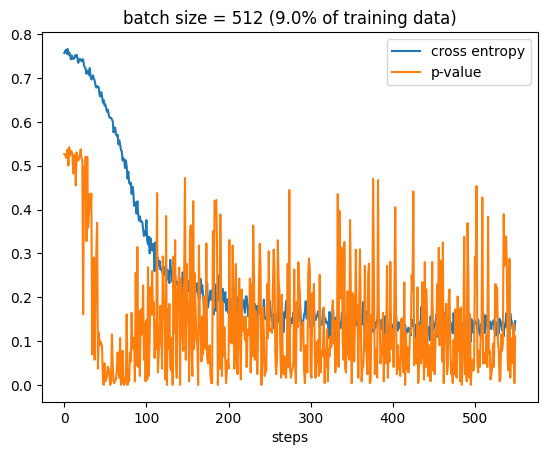

In [17]:
plt.figure()
plt.plot(np.arange(len(l_log)), l_log, label="cross entropy")
plt.plot(np.arange(len(p_log)), p_log, label="p-value")
plt.xlabel("steps")
plt.title(f"batch size = {bs} ({100*bs/len(splits[0]):.2}% of training data)")
plt.legend()
plt.savefig("log.png")

In [5]:

# Training accuracy
train_output, train_targets = learn.get_preds(dl=dls.train, with_loss=False)
train_preds, train_c, _ = train_output
train_acc[sub_test] = accuracy_score(train_targets, train_preds.argmax(dim=1))
print(f"Training acc   : {train_acc[sub_test]}")

# P-value (only makes sense to report for training)
p, _ = cpt_p_pearson(train_c.numpy(), train_preds.argmax(dim=1).numpy(), train_targets.numpy(), cond_like_mat[splits[0],:][:,splits[0]],
                            mcmc_steps=100, random_state=None, num_perm=2000, dtype='categorical')
p_value[sub_test] = p
print(f"P Value        : {p}")

# Validation accuracy
valid_output, valid_targets = learn.get_preds(dl=dls.valid, with_loss=False)
valid_preds, valid_c, _ = valid_output
valid_acc[sub_test] = accuracy_score(valid_targets, valid_preds.argmax(dim=1))
print(f"Validation acc : {valid_acc[sub_test]}")

# Testing accuracy
dls_test = dls.new(dsets_test)
learn.loss_func = CrossEntropyLoss()
learn.metrics = accuracy
test_output, test_targets = learn.get_preds(dl=dls_test, with_loss=False)
test_preds, test_c, _ = test_output
test_acc[sub_test] = accuracy_score(test_targets, test_preds.argmax(dim=1))
print(f"Testing acc : {test_acc[sub_test]}")

if WANDB: wandb.log({"subject_info/vfi_1"    : int(VFI_1[sub_test][0][0]),
                      "metrics/train_acc_opt" : train_acc[sub_test],
                      "metrics/test_acc_opt"  : test_acc[sub_test],
                      "metrics/p_value_opt"   : p_value[sub_test]})

Training acc   : 0.9859080500264225
P Value        : 0.0


Validation acc : 0.9841269841269841


Testing acc : 0.14545454545454545


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from util.sEMGhelpers import load_raw_signals

signals, labels, VFI1, sub_id, sub_skinfold = load_raw_signals("../data/subjects_40_v6.mat")

# convert from (4,) to (165, 4, 4000)
X = []
Y = []
for i in range(40):
  # normalize the signal subject-wise
  x = np.stack(signals[i], axis=2)
  x_means = np.mean(x, axis=(0,1))
  x_stds = np.std(x, axis=(0,1))
  x_norm = (x - x_means[np.newaxis, np.newaxis, :]) / x_stds[np.newaxis, np.newaxis, :]

  # one-hot encode the binary labels
  N = labels[i][0].shape[0]
  mapped_indices = (labels[i][0] == 1).astype(int)
  y = np.zeros((N, 2))
  y[np.arange(N), mapped_indices.flatten()] = 1

  X.append(x_norm)
  Y.append(y)

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

print(X.shape)
print(Y.shape)

SyntaxError: invalid syntax (3348548848.py, line 15)

In [54]:
np.stack(signals[0], axis=2).shape

(165, 4000, 4)

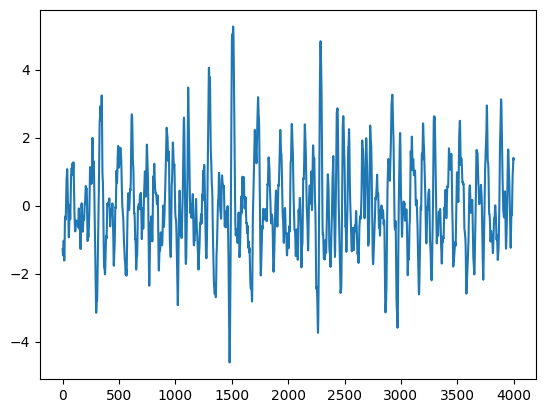

In [39]:
plt.figure()
plt.plot(x_norm[0,3,:])
plt.show()